## AMES Housing Project 
<hr/>

### 1 - Data Cleaning and EDA

### Problem Statement

Prospective homeowners are faced with a deluge of considerations when it comes to decisions regarding property purchase. Some of these considerations might include:
1) What is the condition of the property? <br>
2) How old is the property? <br>
3) Will the value of my property rise? Is this dependent on what kind of future development will take place near my area (e.g. Industrial/Commercial, etc.)? <br>

We want to help prospective homeowners in Ames, Iowa to make informed decisions about which property they should consider purchasing for best value. We also want to help prospective sellers to determine how to maximise the value of their sales. <br>

Specifically, our problem statement is as such:

**Which features of a property will have an effect on the sale price?** <br>

In this project, we will be building and evaluating machine learning models to help predict housing prices based on a set of features.

### Executive Summary

We use the dataset of residential property sold in Ames, Iowa from 2006 to 2010. The data dictionary can be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt). <br>
To build the model, we did the following steps: <br>
1) Read the data into a pandas dataframe <br>
2) Grouped the data into categories and filled the null values <br>
3) Performed exploratory data analysis to examine relationships between features. (using correlation and looking at their distributions). <br>
4) Transformed other features to minimise multicollinearity by adding them together or dropping them. <br>
5) Built and evaluated Linear, Ridge and Lasso models using a preselected set of 23 features. <br>
6) Hot encoded categorical features then merged them back together with scaled numerical features. Total features used was 117.<br>
6) Selected features (64) not zeroed out by Lasso to build final production model. <br>
7) Submitted model predictions to kaggle to assess how well the model generalises against unseen data. <br>



### Findings

For the set of features that were selected to build the Linear, Lasso and Ridge regression models, we found that the Ridge regression model performed the best, achieving low RMSE and high R2 scores consistently for both train and holdout test sets. We therefore selected Ridge regression as the final production model for our submission to Kaggle. 

Our final RMSE was around 30895 (scored by Kaggle) against our own training prediction RMSE of around 25880. This seems to imply that our model generalises reasonably well on unseen data.

For the top features that have an impact on property sale prices:
1) **Neighborhood**: The neighborhood the property is located in. <br> <br>
2) **Quality**: The overall finishing and material of the house. <br><br> 
3) **Square Feet**: The size of the property. <br> <br>
4) **Materials e.g. Foundation, Roof** : The materials used to construct the property <br> <br>

Surprisingly, the age of the property did not influence the sale price as much as we initially assumed. It was zeroed out by lasso.

### Content:
* [Data Cleaning](#dataclean)
* [Exploratory Data Analysis](#EDA)
* [Dropping Features](#dropf)

## Data Cleaning <a class="anchor" id="dataclean"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
house_tr = pd.read_csv("datasets/train.csv") #read dataset

In [3]:
pd.set_option('display.max_columns', len(house_tr.columns)) #display all columns
pd.set_option('display.max_rows', len(house_tr)) #display all rows

#### Preliminary Observations of Dataset

The Ames Housing dataset has 2051 rows and 81 columns of data. Each row represents a property. The columns represent features of the property that inform us on the condition and quality, type of dwelling, ratings of different areas of the property e.g. Pool, Basement etc. <br>

Based on the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) from the Ames, Iowa Assessor's Office, there are 23 nominal, 23 ordinal, 14 discrete and 20 continuous variable columns, with 2 observation identifiers (Id and PID). <br> 

There are 26 columns with null values. The null values range from 1 to 2042. A possibility for the null values could be that some property may not come with these features, such as a pool, tennis courts or elevators. <br>

This means that even though there are null values, they might not be missing at random. We will need to drill down deeper and compare each feature with the data dictionary to better understand these null values before deciding to impute or remove them.

In [4]:
house_tr.head() #get a preliminary sense of the data

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
house_tr.shape #2051 rows and 81 columns in the dataframe

(2051, 81)

In [6]:
house_tr.isnull().sum().sort_values(ascending=False) #there are a lot of null values in the data, but they may not be incorrect

Pool QC            2042
Misc Feature       1986
Alley              1911
Fence              1651
Fireplace Qu       1000
Lot Frontage        330
Garage Finish       114
Garage Cond         114
Garage Qual         114
Garage Yr Blt       114
Garage Type         113
Bsmt Exposure        58
BsmtFin Type 2       56
BsmtFin Type 1       55
Bsmt Cond            55
Bsmt Qual            55
Mas Vnr Type         22
Mas Vnr Area         22
Bsmt Half Bath        2
Bsmt Full Bath        2
Garage Cars           1
Garage Area           1
Bsmt Unf SF           1
BsmtFin SF 2          1
Total Bsmt SF         1
BsmtFin SF 1          1
Overall Cond          0
Exterior 2nd          0
Exterior 1st          0
Roof Matl             0
Roof Style            0
Year Remod/Add        0
Year Built            0
SalePrice             0
Overall Qual          0
Land Contour          0
PID                   0
MS SubClass           0
MS Zoning             0
Lot Area              0
Street                0
Lot Shape       

In [7]:
#count columns with null values
zero_df = pd.DataFrame(house_tr.isnull().sum(), columns = ['na_values'])
zero_df = zero_df[zero_df['na_values'] != 0]
print(zero_df.shape)

(26, 1)


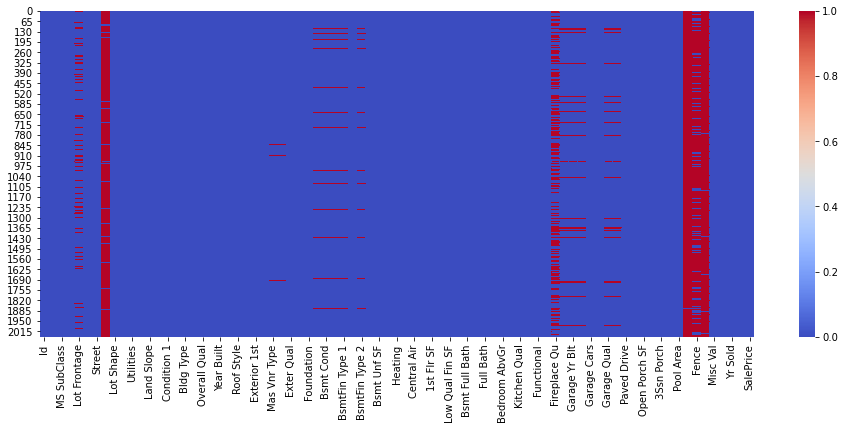

In [8]:
#visualising null values
plt.figure(figsize=(16,6))
sns.heatmap(
    house_tr.isnull(),
    cmap ='coolwarm'
);

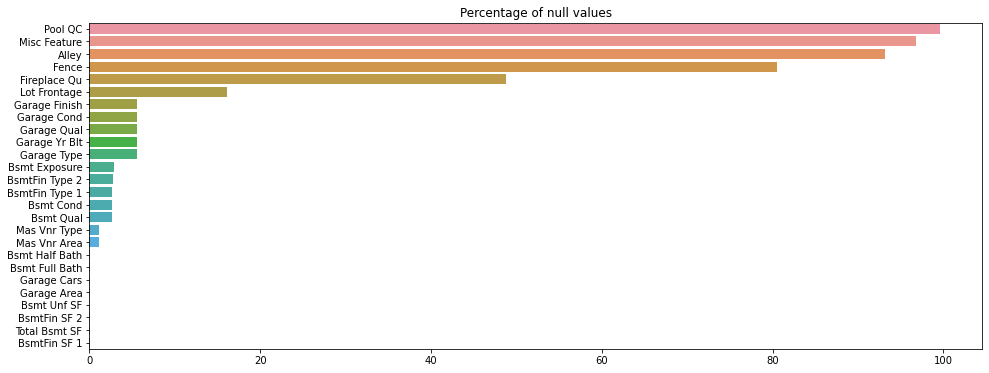

In [9]:
#plotting percentage of null variables by features
null_vals = house_tr.isnull().sum().sort_values(ascending=False)
null_perc = null_vals[null_vals.values > 0] / house_tr.shape[0] * 100

plt.figure(figsize=(16,6))
ax = sns.barplot(
    x = null_perc.values,
    y = null_perc.index,
)

ax.set_title('Percentage of null values');

Some features like Pool QC, Misc Feature, Alley have more than 80% null values.

We might want to drop some of the columns/features with a lot of missing data, but before that we should apply deductive imputation to better understand the data before dropping it.

In [10]:
house_tr['Pool QC'].unique() #looking at unique categories in top 2 columns with most missing values 

array([nan, 'Fa', 'Gd', 'Ex', 'TA'], dtype=object)

In [11]:
house_tr['Misc Feature'].unique() #looking at unique categories in top 2 columns with most missing values 

array([nan, 'Shed', 'TenC', 'Gar2', 'Othr', 'Elev'], dtype=object)

In [12]:
house_tr.dtypes #get a sense of the data types for each column

Id                   int64
PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
B

#### Dealing with null values
An approach to deal with these null values would be to: <br>
1) organise them based on their types, e.g. Categorical, Nominal, Ordinal etc based on the data dictionary <br>
2) look up their definitions on the data dictionary <br>
3) decide on the imputation method deductively or drop the column <br>

In [13]:
#rename columns to lowercase and remove spacing
house_tr.columns = house_tr.columns.str.replace(' ', '')
house_tr.columns = house_tr.columns.str.lower()
house_tr.head()

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremod/add,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


#### Clean Ordinal Variables

In [14]:
# Group ordinal variables

ords = ['lotshape', 'utilities', 'landslope', 'overallqual', 
        'overallcond', 'exterqual', 'extercond', 'bsmtqual', 'bsmtcond', 
        'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heatingqc',
        'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagefinish',
        'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence']

house_tr[ords].isnull().sum().sort_values(ascending=False) #ordinal variables with null values in descending order

poolqc          2042
fence           1651
fireplacequ     1000
garagecond       114
garagequal       114
garagefinish     114
bsmtexposure      58
bsmtfintype2      56
bsmtfintype1      55
bsmtcond          55
bsmtqual          55
kitchenqual        0
electrical         0
heatingqc          0
functional         0
paveddrive         0
extercond          0
exterqual          0
overallcond        0
overallqual        0
landslope          0
utilities          0
lotshape           0
dtype: int64

<AxesSubplot:>

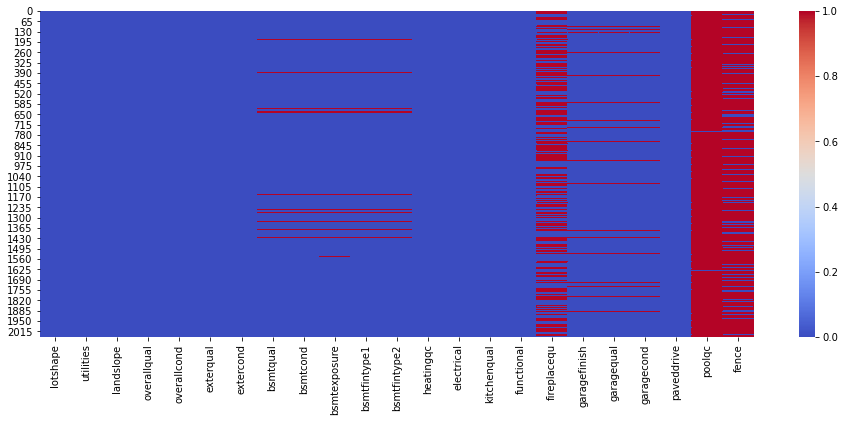

In [15]:
#visualising missing ordinal variables
plt.figure(figsize=(16,6))
sns.heatmap(
    house_tr[ords].isnull(),
    cmap = 'coolwarm'
)

This tells us that a large chunk of data in ordinal variables that are null come from fence, poolqc, and fireplacequ. We will need to look at the data dictionary to further examine the variables with null values. We may consider eventually dropping these features as there is a significantly high amount of data that is null. 

#### Observations after comparing ordinal variables with data dictionary

As mentioned in the preliminary observations, the null values in these columns are not missing at random. <br> 
Comparing the columns and unique values with the data dictionary, null values would most likely mean the properties do not have facilities such as a garage, fireplace or pool. <br>

We note here that basement ordinal variables do not seem to tally. There are more null values in bsmtexposure and bsmtfintype2. This implies there could be data missing at random (MAR) here. 

In [16]:
# Checking on basement ordinal variables
bsmt_check = ['bsmtexposure', 'bsmtfintype1', 'bsmtfintype2']
#assumption that only 55 properties have no basement.
house_tr.loc[(house_tr['bsmtexposure'].isnull()) | (house_tr['bsmtfintype1'].isnull()) | (house_tr['bsmtfintype2'].isnull()) , bsmt_check] 

,bsmtexposure,bsmtfintype1,bsmtfintype2
12,NaN,NaN,NaN
93,NaN,NaN,NaN
114,NaN,NaN,NaN
146,NaN,NaN,NaN
183,NaN,NaN,NaN
240,NaN,NaN,NaN
249,NaN,NaN,NaN
256,NaN,NaN,NaN
390,NaN,NaN,NaN
437,NaN,NaN,NaN


For column bsmtexposure, there are 3 rows of data (1456, 1547, 1997) with NaN that do not have NaN for bsmtfintype1 and bsmtfintype2. <br>

For column bsmtfintype2, there is 1 row of data(1147) with NaN that does not have NaN for bsmtexposure and bsmtfintype1. <br>

This means that the data is MAR as we suspected earlier and we will need impute the null values. <br>


In [17]:
house_tr['bsmtexposure'].mode()

0    No
dtype: object

In [18]:
#imputing null values for bsmtexposure using mode
house_tr.loc[[1456, 1547, 1997], 'bsmtexposure'] = 'No' #no means no walkout or garden level walls

In [19]:
house_tr['bsmtfintype2'].mode()

0    Unf
dtype: object

In [20]:
#imputing null values for bsmtfintype2 using mode
house_tr.loc[[1147], 'bsmtfintype2'] = 'Unf'  #unf means unfinished basement

We want to consider encoding the ordinal variables, as we will likely be using them for visualisation to explore relationships and do statistical modelling.

In [21]:
# Encode the ordinal variables using the replace method

house_tr.lotshape.replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)
house_tr.utilities.replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)
house_tr.landslope.replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)
house_tr.exterqual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.extercond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.bsmtqual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.bsmtcond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.bsmtexposure.replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)
house_tr.bsmtfintype1.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
house_tr.bsmtfintype2.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
house_tr.heatingqc.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.electrical.replace({'Mix': 1, 'FuseP': 2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5}, inplace=True)
house_tr.kitchenqual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.functional.replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)
house_tr.fireplacequ.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.garagefinish.replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)
house_tr.garagequal.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.garagecond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.paveddrive.replace({'N':1, 'P':2, 'Y':3}, inplace=True)
house_tr.poolqc.replace({'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
house_tr.fence.replace({'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}, inplace=True)

house_tr[ords] = house_tr[ords].fillna(0) #replace null with zero

In [22]:
house_tr[ords].isnull().sum().sort_values(ascending=False) #ordinal variables are now clean

fence           0
bsmtfintype1    0
utilities       0
landslope       0
overallqual     0
overallcond     0
exterqual       0
extercond       0
bsmtqual        0
bsmtcond        0
bsmtexposure    0
bsmtfintype2    0
poolqc          0
heatingqc       0
electrical      0
kitchenqual     0
functional      0
fireplacequ     0
garagefinish    0
garagequal      0
garagecond      0
paveddrive      0
lotshape        0
dtype: int64

####  Clean Nominal Variables

In [23]:
#group nominal variables

noms = ['mssubclass', 'mszoning', 'street', 'alley', 'landcontour',
        'lotconfig', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
        'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 
        'exterior2nd', 'masvnrtype', 'foundation', 'heating', 'centralair',
        'garagetype', 'miscfeature', 'saletype']

house_tr[noms].isnull().sum().sort_values(ascending=False) #nominal variables with null values in descending order

miscfeature     1986
alley           1911
garagetype       113
masvnrtype        22
saletype           0
condition2         0
mszoning           0
street             0
landcontour        0
lotconfig          0
neighborhood       0
condition1         0
housestyle         0
bldgtype           0
roofstyle          0
roofmatl           0
exterior1st        0
exterior2nd        0
foundation         0
heating            0
centralair         0
mssubclass         0
dtype: int64

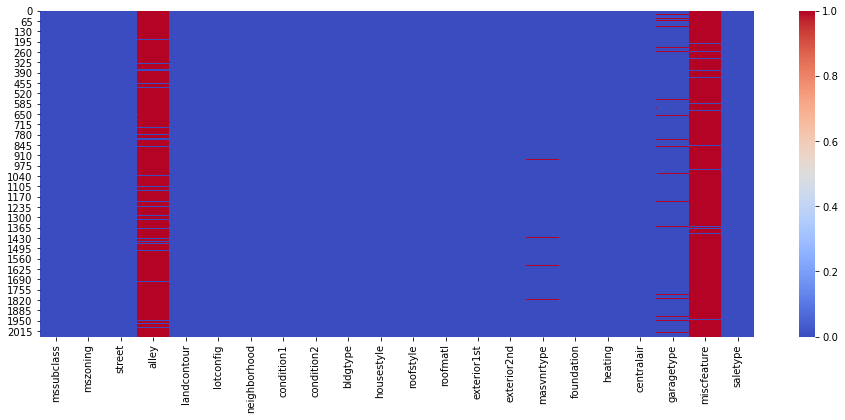

In [24]:
#visualising features with null values
plt.figure(figsize=(16,6))
sns.heatmap(
    house_tr[noms].isnull(),
    cmap = 'coolwarm'
);

We see here for the nominal variables that alley and miscfeature has a large chunk of null values as data. We will need to further examine this by comparing the column and values with the data dictionary.

#### Observations after comparing nominal variables with data dictionary

As mentioned in the preliminary observations, the null values in these columns are not missing at random. <br> 
Comparing the columns and unique values with the data dictionary, null values would most likely mean the properties do not have facilities such as a garage, alley access or masonry veneer. We may consider eventually dropping these features as there is a significantly high amount of data that is null.  <br>

We note here that garage value does not tally with the other ordinal variables for garage (113 null values vs 114 null values). 


In [25]:
#checking garagetype to investigate discrepancy 
gar_check = ['garagetype', 'garagequal', 'garagefinish', 'garagecond']

house_tr.loc[(house_tr['garagetype'].notnull()) & (house_tr['garagequal']==0), gar_check]

,garagetype,garagequal,garagefinish,garagecond
1712,Detchd,0.0,0.0,0.0


We assume that this is a data entry error as the other garage related variables we cleaned earlier were null values. We will drop this row and replace all the other values with 'None' for now. <br> We will explore which features might be interesting for us to include and hot encode after we perform the exploratory data analysis(EDA).

In [26]:
house_tr.drop(index=[1712], inplace=True)

In [27]:
house_tr[noms] = house_tr[noms].fillna('None')

In [28]:
house_tr[noms].isnull().sum().sort_values(ascending=False) #nominal variables are now clean

saletype        0
miscfeature     0
mszoning        0
street          0
alley           0
landcontour     0
lotconfig       0
neighborhood    0
condition1      0
condition2      0
bldgtype        0
housestyle      0
roofstyle       0
roofmatl        0
exterior1st     0
exterior2nd     0
masvnrtype      0
foundation      0
heating         0
centralair      0
garagetype      0
mssubclass      0
dtype: int64

#### Clean Discrete and Continuous Variables

In [29]:
#group discrete and continuous variables together

dis_cons = [col for col in house_tr.columns if col not in ords and col not in noms]

#remove observer/identifier variables as we do not need to clean them
dis_cons.remove('id')
dis_cons.remove('pid')


In [30]:
house_tr[dis_cons].isnull().sum().sort_values(ascending=False) #discrete/continuous variables with null values in descending order

lotfrontage      330
garageyrblt      113
masvnrarea        22
bsmtfullbath       2
bsmthalfbath       2
bsmtfinsf1         1
bsmtfinsf2         1
totalbsmtsf        1
bsmtunfsf          1
yearremod/add      0
fullbath           0
1stflrsf           0
2ndflrsf           0
yearbuilt          0
lowqualfinsf       0
grlivarea          0
lotarea            0
saleprice          0
yrsold             0
bedroomabvgr       0
kitchenabvgr       0
totrmsabvgrd       0
fireplaces         0
garagecars         0
garagearea         0
wooddecksf         0
openporchsf        0
enclosedporch      0
3ssnporch          0
screenporch        0
poolarea           0
miscval            0
mosold             0
halfbath           0
dtype: int64

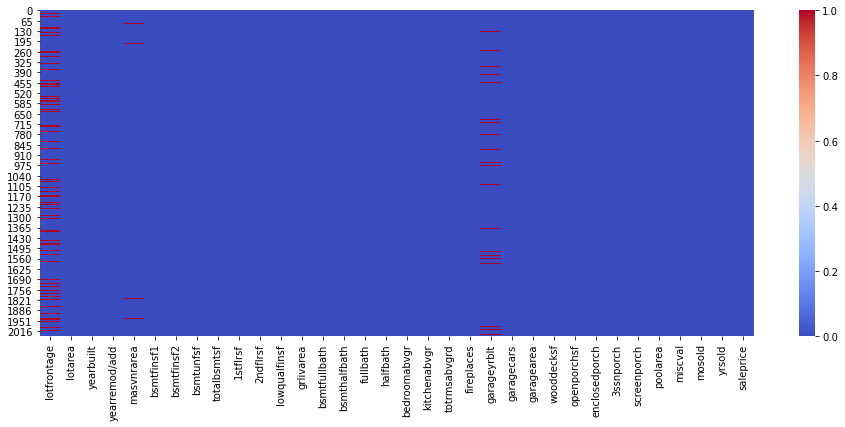

In [31]:
#visualising features with null values
plt.figure(figsize=(16,6))
sns.heatmap(
    house_tr[dis_cons].isnull(),
    cmap = 'coolwarm'
);

Compared to ordinal and nominal variables, there are generally lesser null values for each feature. Some null values in the features are not missing at random. <br>

We compare the features and their values with the data dictionary. For the garage and basement related variables, if there are null values, it most likely indicates that there is no garage or basement for the property. This is also similar for features such as lotfrontage (linear feet of street connected to property) and masvnrarea(masonry veneer area). Null values would mean that the property likely has no street connected to it or no masonry veneer area. <br>

We will now investigate each column and perform the corresponding imputation. In some cases we should be able to impute the null values as zero to indicate absence of the facility or feature.

In [32]:
#lotfrontage is a continuous variable for linear feet of street connect to property.
# not possible to have property not connected to street so we will impute lotfrontage with median
house_tr['lotfrontage'] = house_tr['lotfrontage'].fillna(house_tr['lotfrontage'].median())

In [33]:
#masvnrarea is a continuous variable for Masonry veneer area in square feet
# null values might mean no masonry veneer
house_tr['masvnrarea'] = house_tr['masvnrarea'].fillna(0)

In [34]:
#checking garage variables
garage_check = ['garageyrblt', 'garagecars', 'garagearea', 'garagetype']

# data below indicates that these properties likely have no garage
# since most of the other garage related values are 0 or 'None'.
house_tr.loc[(house_tr['garageyrblt'].isnull()) | (house_tr['garagecars'].isnull()) | (house_tr['garagearea'].isnull()), garage_check]

,garageyrblt,garagecars,garagearea,garagetype
28,NaN,0.0,0.0,None
53,NaN,0.0,0.0,None
65,NaN,0.0,0.0,None
79,NaN,0.0,0.0,None
101,NaN,0.0,0.0,None
103,NaN,0.0,0.0,None
114,NaN,0.0,0.0,None
120,NaN,0.0,0.0,None
134,NaN,0.0,0.0,None
136,NaN,0.0,0.0,None


In [35]:
#imputing garage related discrete/continuous variables with 0
house_tr[['garageyrblt', 'garagecars', 'garagearea']] = house_tr[['garageyrblt', 'garagecars', 'garagearea']].fillna(0)

In [36]:
#checking basement variables

bsmt_check = ['bsmthalfbath', 'bsmtfullbath', 'bsmtfinsf1', 'bsmtfinsf2','bsmtunfsf', 'totalbsmtsf', 'bsmtqual']

# data below indicates that these properties likely have no basement and basement baths
# since most of the other related values are 0.

house_tr.loc[(house_tr['bsmthalfbath'].isnull()) | (house_tr['bsmtfullbath'].isnull()) | (house_tr['bsmtfinsf1'].isnull()) | (house_tr['bsmtfinsf2'].isnull())
            | (house_tr['bsmtunfsf'].isnull()) | (house_tr['totalbsmtsf'].isnull()), bsmt_check]

,bsmthalfbath,bsmtfullbath,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,bsmtqual
616,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1327,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [37]:
#imputing basement related discrete/continuous variables with 0
base_var = ['bsmthalfbath', 'bsmtfullbath', 'bsmtfinsf1', 'bsmtfinsf2','bsmtunfsf', 'totalbsmtsf']
house_tr[base_var] = house_tr[base_var].fillna(0)

In [38]:
house_tr[dis_cons].isnull().sum().sort_values(ascending=False) #discrete and continuous variables are now clean

saleprice        0
totalbsmtsf      0
bsmthalfbath     0
bsmtfullbath     0
grlivarea        0
lowqualfinsf     0
2ndflrsf         0
1stflrsf         0
bsmtunfsf        0
yrsold           0
bsmtfinsf2       0
bsmtfinsf1       0
masvnrarea       0
yearremod/add    0
yearbuilt        0
lotarea          0
fullbath         0
halfbath         0
bedroomabvgr     0
kitchenabvgr     0
totrmsabvgrd     0
fireplaces       0
garageyrblt      0
garagecars       0
garagearea       0
wooddecksf       0
openporchsf      0
enclosedporch    0
3ssnporch        0
screenporch      0
poolarea         0
miscval          0
mosold           0
lotfrontage      0
dtype: int64

#### Adding 'agesold' column to dataframe
We note some features that are related to time. By instinct, we know that the age of a property could also influence the sale price. We can derive the age of the property using the 'yrsold' and 'yrbuilt' features.





In [39]:
#creating the agesold feature using difference of yearbuilt and yrsold

house_tr['agesold'] = house_tr['yrsold'] - house_tr['yearbuilt']

#### Summary statistics

The average sale price for the properties in the dataset was about \\$181,469.70  The lowest sale price was about \\$12,789 , and the highest sale price was about \\$611,657. The median sale price was about $162,500. This is presumed to be in US dollars. <br> <br>
The properties were sold from 2006 to 2010. The houses were built from 1872 to 2010. <br><br>
The average size/living area of the property was around 1499.3 square feet. The smallest living area was around 334 square feet and the largest living area was around 5,649 square feet. The median living area was about 1,499 square feet.

In [40]:
house_tr.describe().T #get summary statistics of data

,count,mean,std,min,25%,50%,75%,max
id,2050.0,1.473661e+03,8.440184e+02,1.0,7.532500e+02,1483.5,2.196500e+03,2930.0
pid,2050.0,7.134941e+08,1.886879e+08,526301100.0,5.284581e+08,535453180.0,9.071790e+08,924152030.0
mssubclass,2050.0,5.700244e+01,4.283371e+01,20.0,2.000000e+01,50.0,7.000000e+01,190.0
lotfrontage,2050.0,6.889463e+01,2.131100e+01,21.0,6.000000e+01,68.0,7.800000e+01,313.0
lotarea,2050.0,1.006570e+04,6.744097e+03,1300.0,7.500000e+03,9432.0,1.151425e+04,159000.0
lotshape,2050.0,1.404390e+00,5.665822e-01,1.0,1.000000e+00,1.0,2.000000e+00,4.0
utilities,2050.0,3.998537e+00,4.937684e-02,2.0,4.000000e+00,4.0,4.000000e+00,4.0
landslope,2050.0,2.947317e+00,2.443208e-01,1.0,3.000000e+00,3.0,3.000000e+00,3.0
overallqual,2050.0,6.112683e+00,1.426407e+00,1.0,5.000000e+00,6.0,7.000000e+00,10.0
overallcond,2050.0,5.561951e+00,1.104724e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.0


We note that there is a negative value in the agesold feature that we created. We will proceed to look into it and clean it up.

In [41]:
#locating the negative agesold value
yr_check = ['yearbuilt','yrsold', 'agesold']
house_tr[yr_check].sort_values(by='agesold').head()

,yearbuilt,yrsold,agesold
1885,2008,2007,-1
1024,2007,2007,0
1825,2007,2007,0
1060,2009,2009,0
1603,2006,2006,0


The property seems to have been sold before it was built. This is a likely situation for property purchases. For this case we will set agesold to 0.

In [42]:
#changing the negative value to 0
house_tr.loc[[1885], ['agesold']] = 0

In [43]:
house_tr.isnull().sum()

id               0
pid              0
mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
street           0
alley            0
lotshape         0
landcontour      0
utilities        0
lotconfig        0
landslope        0
neighborhood     0
condition1       0
condition2       0
bldgtype         0
housestyle       0
overallqual      0
overallcond      0
yearbuilt        0
yearremod/add    0
roofstyle        0
roofmatl         0
exterior1st      0
exterior2nd      0
masvnrtype       0
masvnrarea       0
exterqual        0
extercond        0
foundation       0
bsmtqual         0
bsmtcond         0
bsmtexposure     0
bsmtfintype1     0
bsmtfinsf1       0
bsmtfintype2     0
bsmtfinsf2       0
bsmtunfsf        0
totalbsmtsf      0
heating          0
heatingqc        0
centralair       0
electrical       0
1stflrsf         0
2ndflrsf         0
lowqualfinsf     0
grlivarea        0
bsmtfullbath     0
bsmthalfbath     0
fullbath         0
halfbath         0
bedroomabvgr

There are no more null values, so we will proceed to save a copy of this cleaned dataset.

In [44]:
house_tr.to_csv('datasets/train_clean.csv', index=False)

### Exploratoratory Data Analysis and Feature Selection <a class="anchor" id="EDA"></a>

We will now proceed to examine the distribution and relationship of each of the features in the dataset, to determine which ones to drop.

#### Creating helper functions to assist in plotting

In [45]:
#histogram subplot function
def subplot_hist(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*6)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        ax[i].hist(dataframe[column],bins=15)
        ax[i].set_title(f'{column} distribution',fontsize=14)
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
        ax[i].axvline(x=dataframe[column].mean() , linewidth=2, color='k', linestyle='dashed')
        ax[i].axvline(x=dataframe[column].median() , linewidth=2, color='g', linestyle='dotted')
        min_ylim, max_ylim = ax[i].get_ylim()
        ax[i].text(x=dataframe[column].mean(), y=max_ylim*0.88, s='Mean', rotation=90, color='k')
        ax[i].text(x=dataframe[column].median(), y=max_ylim*0.85, s='Median', rotation=90, color='g')

In [46]:
# scatterplot subplot function
def subplot_scatter(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(16, nrows*6)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.regplot(y=dataframe.saleprice, x=dataframe[column],ax=ax[i], 
                    scatter_kws={'facecolors':'skyblue','edgecolor':'skyblue'},
                    line_kws = {'color':'grey'})
        ax[i].set_title(f'{column} vs saleprice',fontsize=12)  
        ax[i].tick_params(labelsize=8)
        #ax[i].set_xlabel(column, fontsize=14)
        #ax[i].set_ylabel('saleprice', fontsize=8)

In [47]:
# boxplot subplot function 
def subplot_box(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(16, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.boxplot(x = dataframe[column], y = dataframe.saleprice, width = 0.3, ax = ax[i], color='skyblue')
        ax[i].set_title(column,fontsize=12)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=12)
        ax[i].set_ylabel('saleprice', fontsize=12)
    plt.tight_layout()

In [48]:
#heatmap function

def heat_map(df, list_of_columns):
    list_of_columns.append('saleprice')
    correl = df[list_of_columns].corr()
    mask = np.triu(correl)
    plt.figure(figsize=(16,6))
    plt.title('Correlation Heatmap', fontsize=14)
    sns.heatmap(
        correl,
        cmap='coolwarm',
        mask=mask,
        annot=True
    );
    

#### Correlation

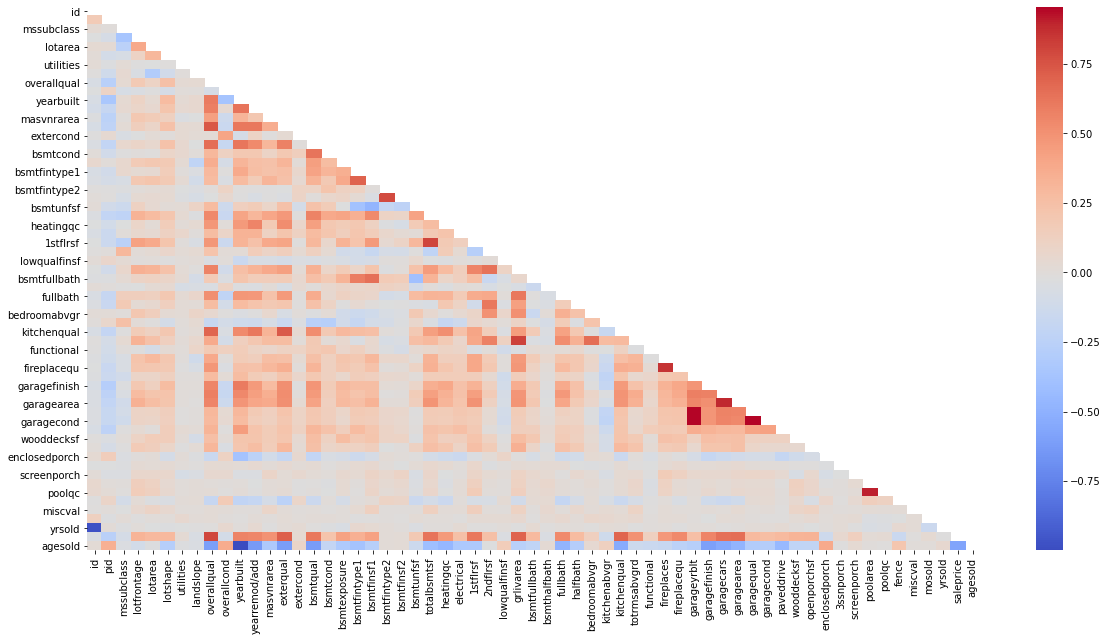

In [49]:
#create a heatmap to view correlation
#mask the heatmap

mask = np.triu(house_tr.corr())
plt.figure(figsize=(20, 10))
sns.heatmap(
    
    house_tr.corr(),
    cmap='coolwarm',
    mask=mask

);

In [50]:
house_tr.corr()

,id,pid,mssubclass,lotfrontage,lotarea,lotshape,utilities,landslope,overallqual,overallcond,yearbuilt,yearremod/add,masvnrarea,exterqual,extercond,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heatingqc,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscval,mosold,yrsold,saleprice,agesold
id,1.000000,0.175415,0.026415,-0.022590,0.032945,0.012024,0.018304,-0.014256,-0.061160,-0.026277,-0.063785,-0.090379,-0.035568,-0.071351,-0.017473,-0.045302,0.007956,0.055866,-0.067408,-0.045905,-0.009481,0.000874,0.008905,-0.037929,-0.029499,-0.054732,-0.022408,-0.008970,0.011769,-0.024178,-0.032974,0.014511,-0.059446,-0.041741,0.010524,-0.002310,-0.065808,-0.008971,-0.020914,-0.037167,-0.025406,-0.037160,-0.065243,-0.048666,-0.045201,-0.044910,-0.043480,-0.062479,-0.009323,0.001697,0.032437,-0.022750,0.009887,0.055735,0.050758,-0.015671,-0.012646,0.128309,-0.975764,-0.051240,0.021330
pid,0.175415,1.000000,-0.003788,-0.082824,0.024217,-0.093633,-0.031646,-0.116770,-0.265576,0.106692,-0.346530,-0.177093,-0.242277,-0.225995,0.039960,-0.199029,-0.109292,0.002337,-0.112596,-0.087092,-0.020919,-0.013139,-0.111580,-0.204463,-0.103962,-0.147756,-0.145626,-0.006267,0.072342,-0.113312,-0.030938,-0.002068,-0.179835,-0.163664,0.009028,0.068539,-0.195120,-0.084881,-0.101508,-0.120297,-0.164050,-0.151806,-0.274268,-0.228368,-0.200891,-0.173569,-0.168580,-0.231318,-0.041553,-0.080798,0.148973,-0.024633,-0.041895,0.005858,0.021402,0.090077,0.004270,-0.032158,0.008780,-0.254933,0.346547
mssubclass,0.026415,-0.003788,1.000000,-0.363782,-0.245469,-0.075211,0.023308,0.042030,0.035885,-0.070204,0.036246,0.044738,-0.002680,0.017380,-0.057062,0.055903,-0.019907,0.054755,0.060618,-0.060461,-0.035216,-0.068089,-0.139221,-0.224651,-0.024329,0.005252,-0.246154,0.305712,0.031108,0.068122,0.025853,-0.016993,0.141997,0.179542,-0.003545,0.252150,-0.019643,0.034533,-0.000087,-0.054994,-0.057583,-0.110710,-0.032805,-0.049148,-0.108228,-0.097601,-0.114759,-0.019536,0.001529,-0.020187,-0.040410,-0.030073,-0.038778,-0.004576,-0.009016,-0.091829,-0.027473,0.013206,-0.032786,-0.087283,-0.037644
lotfrontage,-0.022590,-0.082824,-0.363782,1.000000,0.386719,0.104499,-0.017771,-0.053838,0.182085,-0.049620,0.102921,0.080239,0.197667,0.139375,-0.024103,0.089766,-0.002012,0.172090,0.038186,0.196183,0.000830,0.031973,0.118888,0.330429,0.081663,0.054682,0.427939,0.012302,-0.000054,0.349472,0.098561,-0.028967,0.138392,0.030857,0.199956,0.014763,0.166503,0.331813,-0.018893,0.222960,0.213551,0.087459,0.194075,0.278924,0.337822,0.096469,0.092825,0.035752,0.100370,0.169695,-0.001399,0.028304,0.067740,0.141314,0.153362,0.016777,0.048187,-0.016431,0.008196,0.325036,-0.102407
lotarea,0.032945,0.024217,-0.245469,0.386719,1.000000,0.301751,-0.029800,-0.303643,0.105784,-0.019157,0.035908,0.050829,0.167493,0.089180,0.019601,0.060805,-0.010891,0.195316,0.042584,0.215669,0.020695,0.041779,0.041506,0.277460,0.022168,0.043071,0.381584,0.029505,0.001265,0.327511,0.113243,0.029140,0.125676,0.049948,0.139076,-0.013499,0.119407,0.238710,-0.086345,0.289461,0.201408,0.086138,0.124449,0.214954,0.263296,0.101190,0.091790,-0.001734,0.155684,0.140830,0.014404,0.019545,0.067695,0.115098,0.129196,-0.033503,0.093916,0.003113,-0.029500,0.296550,-0.037080
lotshape,0.012024,-0.093633,-0.075211,0.104499,0.301751,1.000000,-0.013726,-0.106917,0.249153,-0.077082,0.277483,0.221636,0.127664,0.237514,-0.005019,0.232105,0.083762,0.181470,0.154590,0.182375,0.028965,0.033933,0.011256,0.210532,0.160791,0.117753,0.221628,0.070693,-0.015285,0.234126,0.086947,0.045968,0.198524,0.136245,0.023763,-0.092716,0.202318,0.133285,0.024212,0.199487,0.191296,0.124742,0.275069,0.228951,0.215650,0.142

Observing the heat map with the correlation scores, a few things are noteworthy. <br>

**Correlation with saleprice**: There seems to be a high correlation between overallqual, followed by grlivarea, exterqual, kitchenqual and bsmtqual. <br>
**Correlation between independent variables**: exterqual and kitchenqual are also highly correlated with one another (around 0.73), so is 1stflrsf with totalbsmtsf and garagecars with garagearea (around 0.8). When building our prediction model, we will want to avoid including predictors highly correlated with one another to minimise multicollinearity.<br>
**Features with weak correlations**:  Some features, such as poolqc and utilities do not seem to have very strong correlations with others. We will want to drop these.

We will now proceed to further explore the features by the categories we grouped them in earlier while performing data cleaning. As a next step, let us maintain a list of features we want to drop.

In [51]:
drop_features = ['poolqc', 'miscfeature', 'fireplacequ', 'alley', 'fence', 'utilities', 'landscape'] 
# a lot of missing data or low correlation with all other variables

#### Plots for discrete and continuous features

In [52]:
#separate out discrete from continuous variables in dis_cons list earlier
dis = ['bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 
       'totrmsabvgrd', 'fireplaces', 'garagecars', 'agesold', 'yearbuilt', 'yrsold']
cons = [col for col in dis_cons if col not in dis]

#### Exploring discrete features

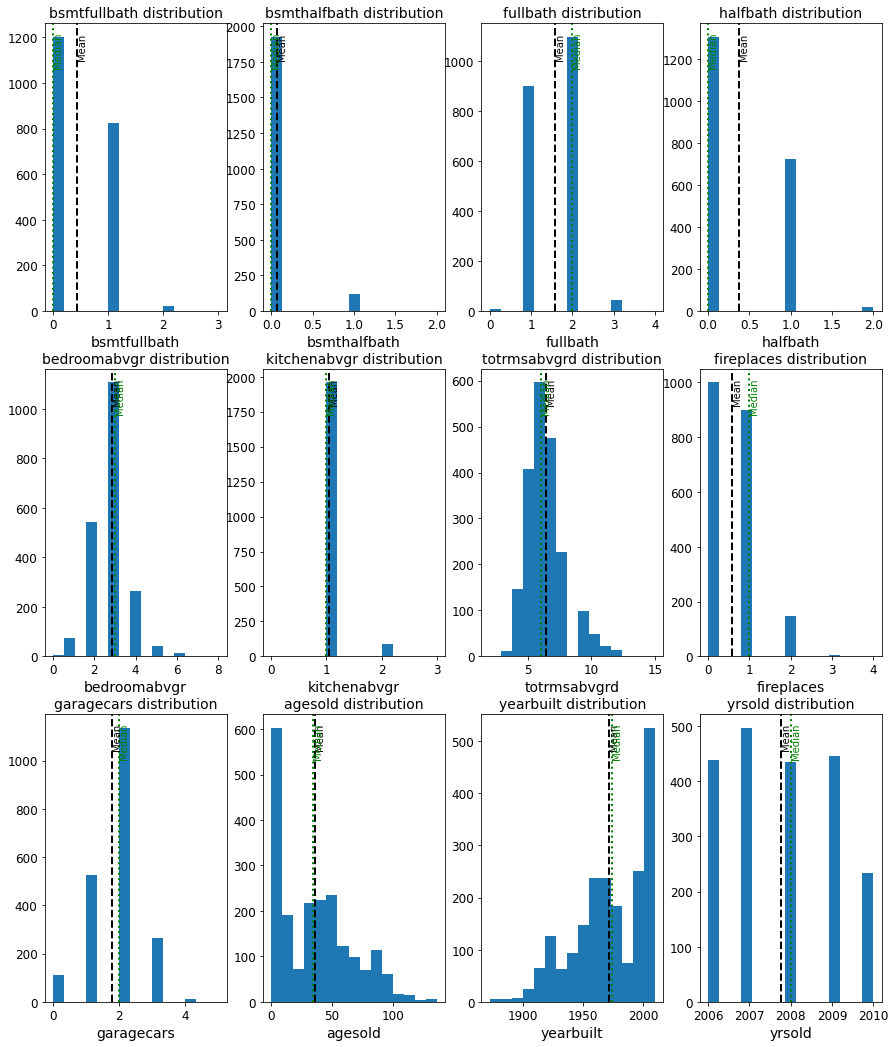

In [53]:
subplot_hist(house_tr, dis)

Observing the median and the mean, we can see that not all of the discrete features follow a normal distribution.

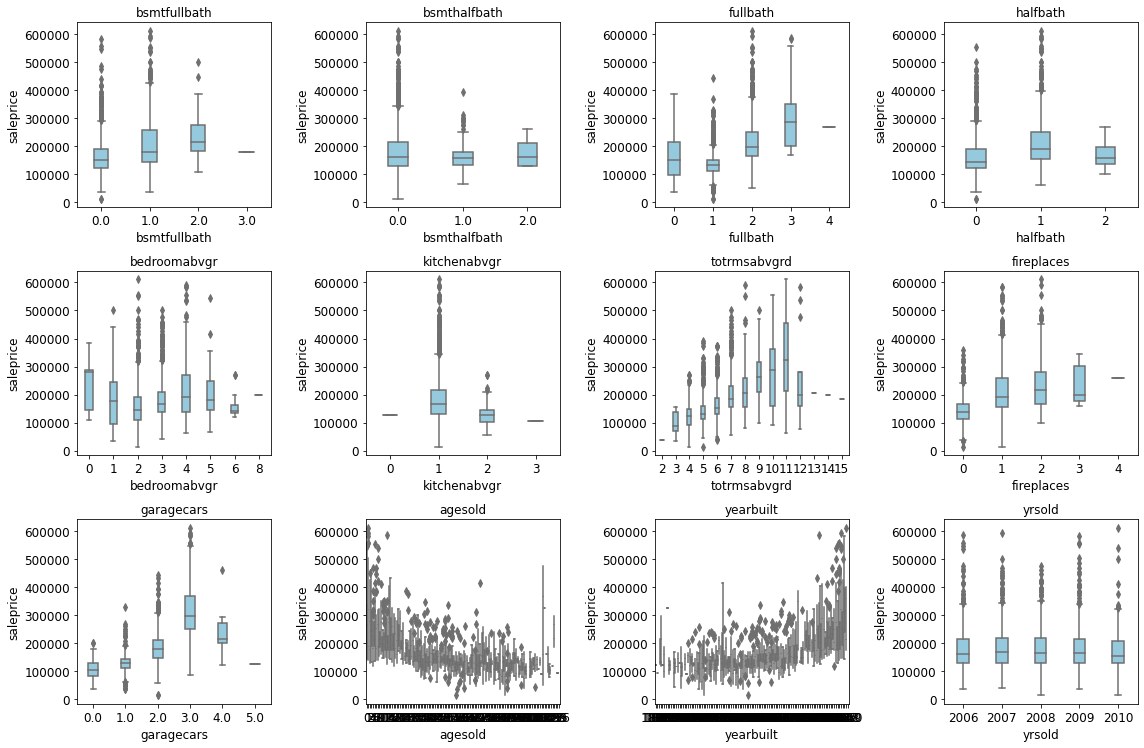

In [54]:
subplot_box(house_tr,dis)

 A few features stand out here. bsmtfullbath, fullbath, garagecars, totrmsabvgrd. The median saleprice for these features generally follows an increasing trend with each unit of increase.

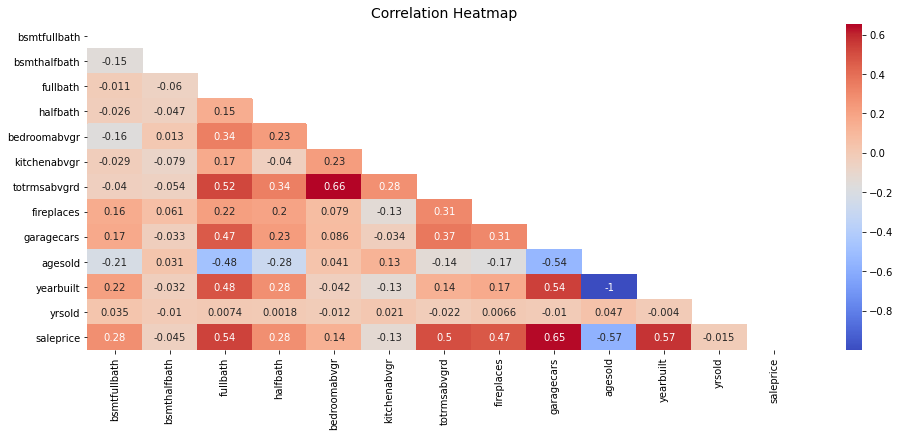

In [55]:
heat_map(house_tr, dis)

In [56]:
#order discrete features by correlation
house_tr[dis].corr()[['saleprice']].sort_values(by='saleprice', ascending=False)

,saleprice
saleprice,1.000000
garagecars,0.648220
yearbuilt,0.571930
fullbath,0.538211
totrmsabvgrd,0.503990
fireplaces,0.471034
bsmtfullbath,0.283235
halfbath,0.282909
bedroomabvgr,0.137109
yrsold,-0.015316


Our feature selection criteria should be that  it has a somewhat strong correlation with saleprice (>0.5), and has no strong correlation with other independent variables. 

For discrete variables, we will drop kitchenabvgr, bsmthalfbath, bedroomabvgr, halfbath, bsmtfullbath, fireplaces and yrsold.	

In [57]:
drop_dis = ['kitchenabvgr', 'bsmthalfbath', 'bedroomabvgr', 'halfbath', 'bsmtfullbath', 'fireplaces', 'yrsold']
drop_features.extend(drop_dis)
drop_features

['poolqc',
 'miscfeature',
 'fireplacequ',
 'alley',
 'fence',
 'utilities',
 'landscape',
 'kitchenabvgr',
 'bsmthalfbath',
 'bedroomabvgr',
 'halfbath',
 'bsmtfullbath',
 'fireplaces',
 'yrsold']

#### Exploring continuous features

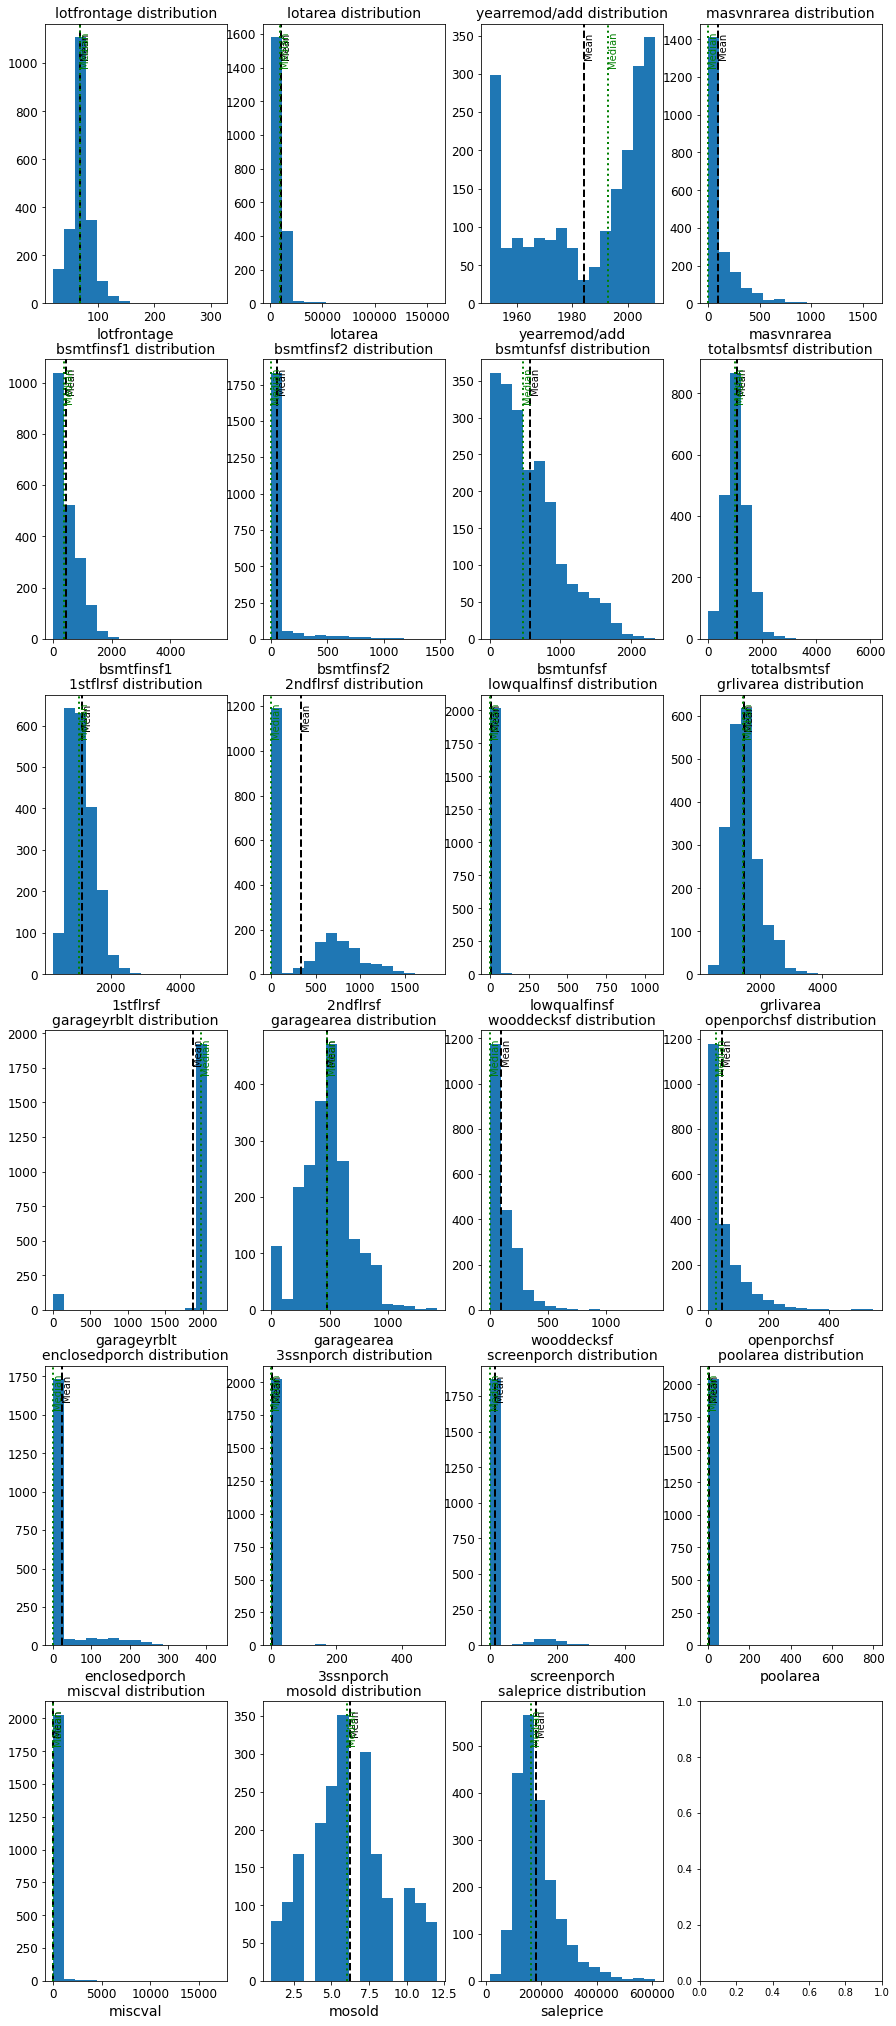

In [58]:
subplot_hist(house_tr, cons)

Observing the median and the mean, it seems like most continuous features follow a normal distribution, e.g.lotfrontage, lotarea, bsmtfnsf1, totalbsmtsf, grlivarea and garagearea. It also seems like most sales are made between the months of June and July.

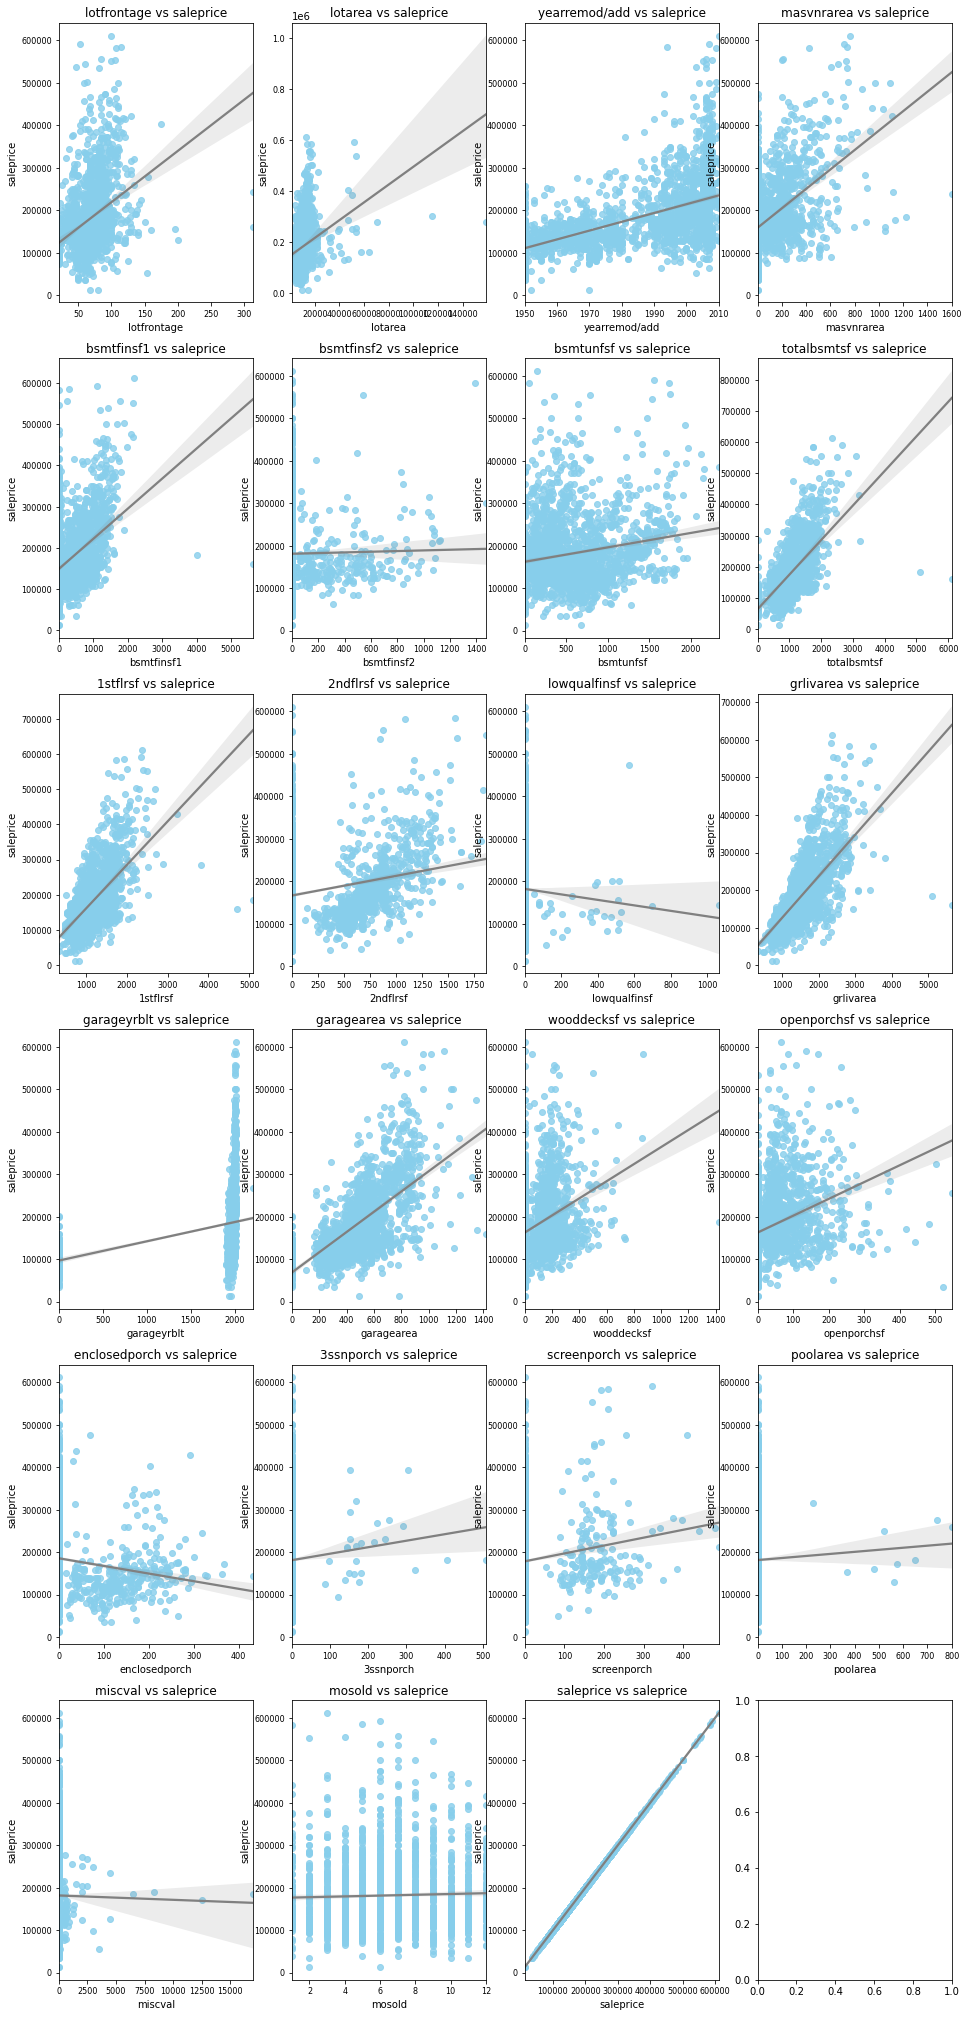

In [59]:
subplot_scatter(house_tr, cons)

We see that a few variables have a strong positive correlation with sale price, such as grlivarea, garagearea, totalbsmtsf, 1stflrsf, yearremod/add, masvnrarea. We also notice in the scatterplot for grlivearea vs saleprice that there seem to be some outliers where homes with large living areas were sold at low prices. We might want to look into this further.

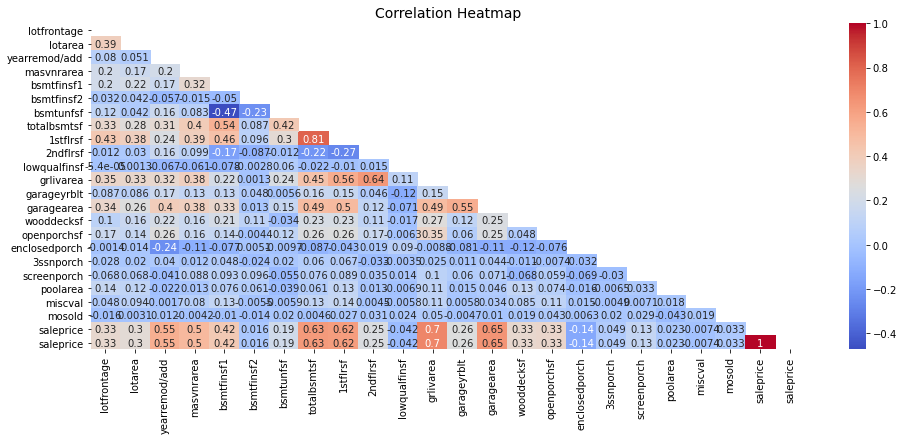

In [60]:
heat_map(house_tr, cons)

In [61]:
#order continuous variables by correlation
cons.remove('saleprice') #remove saleprice as the table below will not display non unique values
house_tr[cons].corr()[['saleprice']].sort_values(by='saleprice', ascending=False)

,saleprice
saleprice,1.000000
grlivarea,0.697261
garagearea,0.650270
totalbsmtsf,0.629273
1stflrsf,0.618451
yearremod/add,0.550589
masvnrarea,0.503530
bsmtfinsf1,0.423920
openporchsf,0.333395
wooddecksf,0.326650


In [62]:
cons.append('saleprice') # append saleprice back into list 

Looking at the histograms, scatterplots and heatmap, we will look at keeping grlivarea, garagearea, firstflrsf and totalbsmtsf as features. We will not take masvnrarea because it looks like there are a lot of zero values in the scatterplot and histogram. This means it might not be useful for our model prediction. We will also combine grlivarea, garagearea and totalbsmtsf to minimise multicollinearity. [(source)](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/).

In [63]:
house_tr['total_sqft'] = house_tr['grlivarea'] + house_tr['totalbsmtsf'] + house_tr['garagearea']

In [64]:
house_tr[['total_sqft', 'saleprice']].corr()

,total_sqft,saleprice
total_sqft,1.000000,0.811879
saleprice,0.811879,1.000000


We note that the correlation between area related features and saleprice has become stronger after being combined.

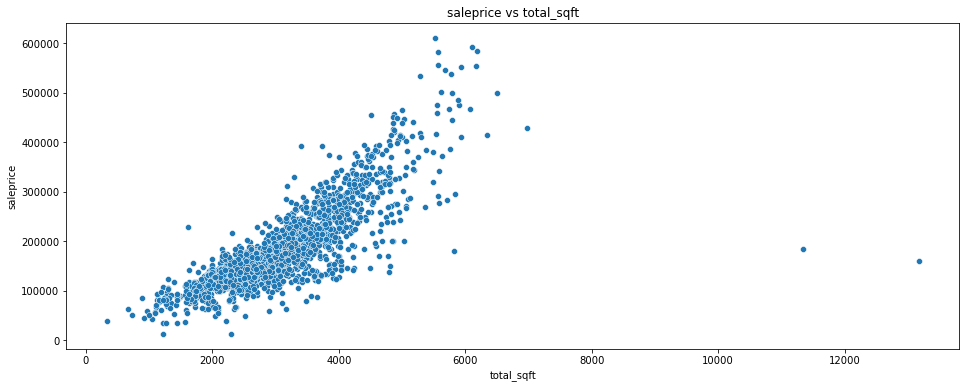

In [65]:
plt.figure(figsize=(16,6))
plt.title('saleprice vs total_sqft')
sns.scatterplot(x='total_sqft', y='saleprice', data=house_tr);

There are 2 outliers which are more obvious after plotting the scatterplot between total_sqft and saleprice.

In [66]:
#dealing with outliers
house_tr.loc[house_tr['total_sqft'] > 10000, ['grlivarea', 'totalbsmtsf', 'garagearea', 'total_sqft', 'saleprice']]

,grlivarea,totalbsmtsf,garagearea,total_sqft,saleprice
960,5642,6110.0,1418.0,13170.0,160000
1885,5095,5095.0,1154.0,11344.0,183850


In [67]:
# We will drop the 2 outliers above

house_tr.drop(index=[960, 1885], inplace=True)

In [68]:
house_tr[['total_sqft', 'saleprice']].corr()

,total_sqft,saleprice
total_sqft,1.000000,0.853733
saleprice,0.853733,1.000000


Correlation has become stronger after removing the outliers. For continuous variables we will keep total_sqft, yearremod/add, masvnrarea, grlivarea and totalbsmtsf.

In [69]:
keep_cons = ['total_sqft', 'yearremod/add', 'masvnrarea', 'grlivarea', 'totalbsmtsf']
drop_cons = [x for x in cons if x not in keep_cons]

In [70]:
drop_features.extend(drop_cons)
drop_features

['poolqc',
 'miscfeature',
 'fireplacequ',
 'alley',
 'fence',
 'utilities',
 'landscape',
 'kitchenabvgr',
 'bsmthalfbath',
 'bedroomabvgr',
 'halfbath',
 'bsmtfullbath',
 'fireplaces',
 'yrsold',
 'lotfrontage',
 'lotarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'garageyrblt',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 '3ssnporch',
 'screenporch',
 'poolarea',
 'miscval',
 'mosold',
 'saleprice',
 'saleprice']

In [71]:
drop_features.remove('saleprice') 

In [72]:
len(drop_features)

33

#### Exploring Ordinal Features

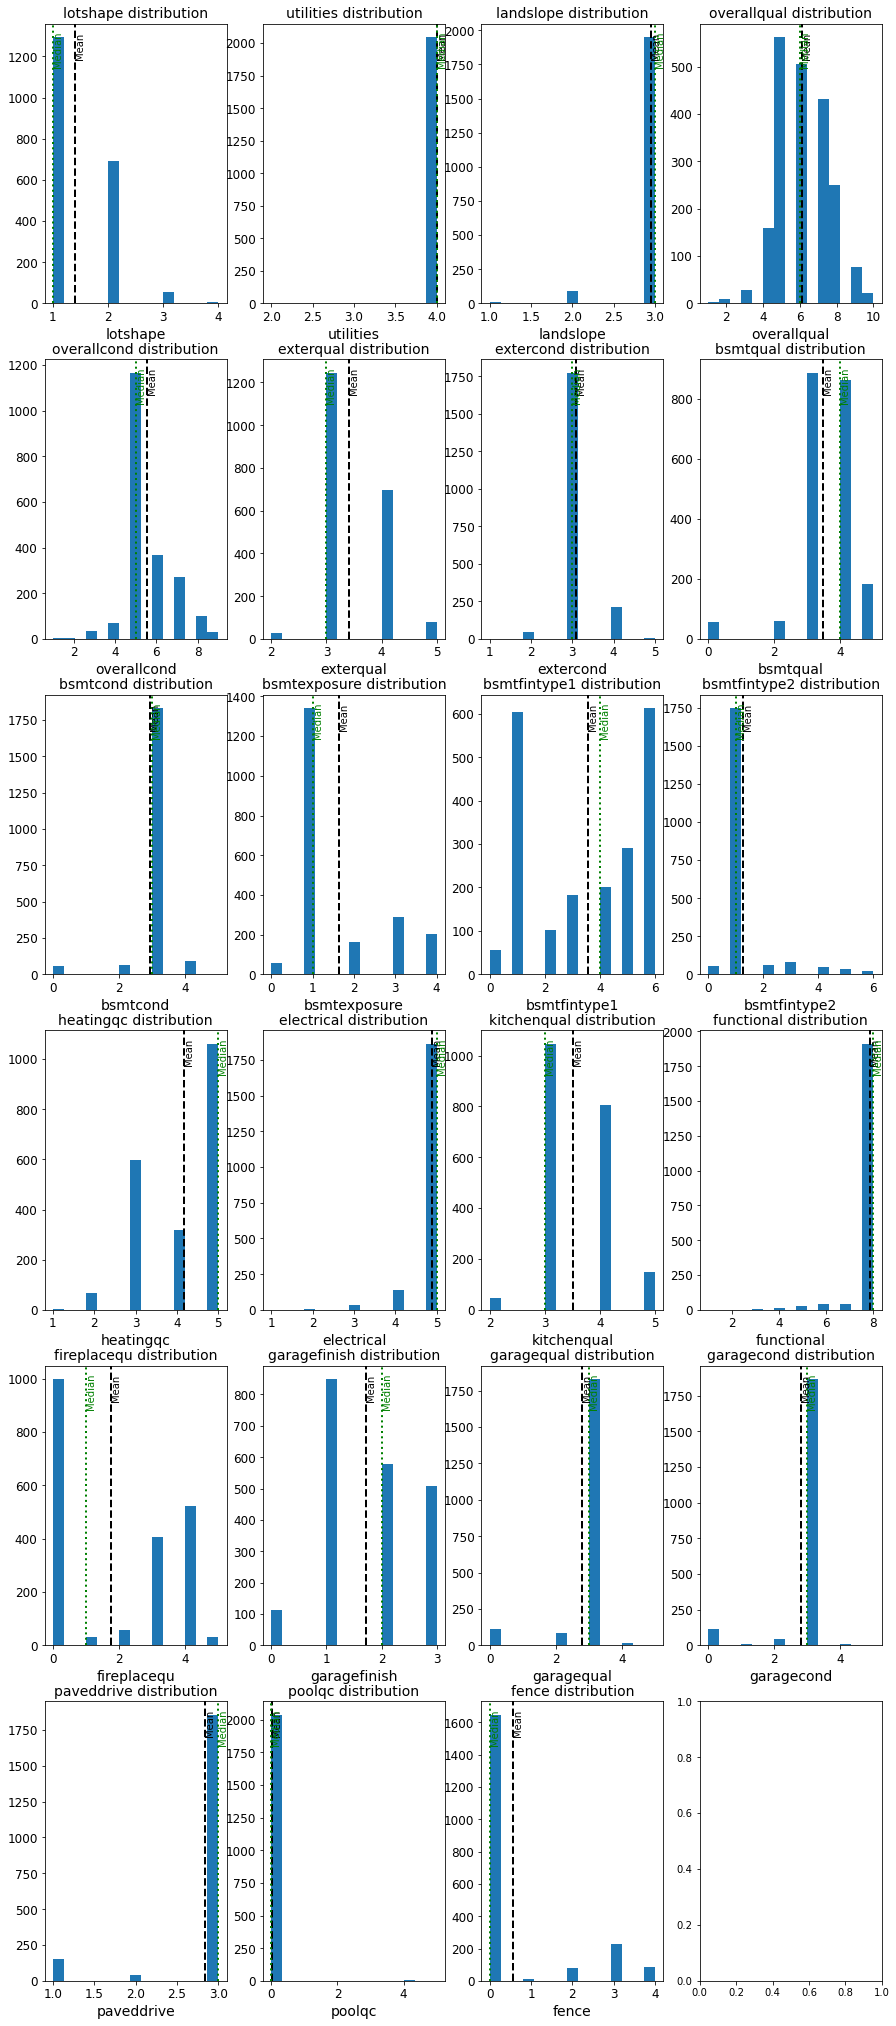

In [73]:
subplot_hist(house_tr, ords)

For ordinal features, we see that overallqual and bsmtcond seems to follow a normal distribution.

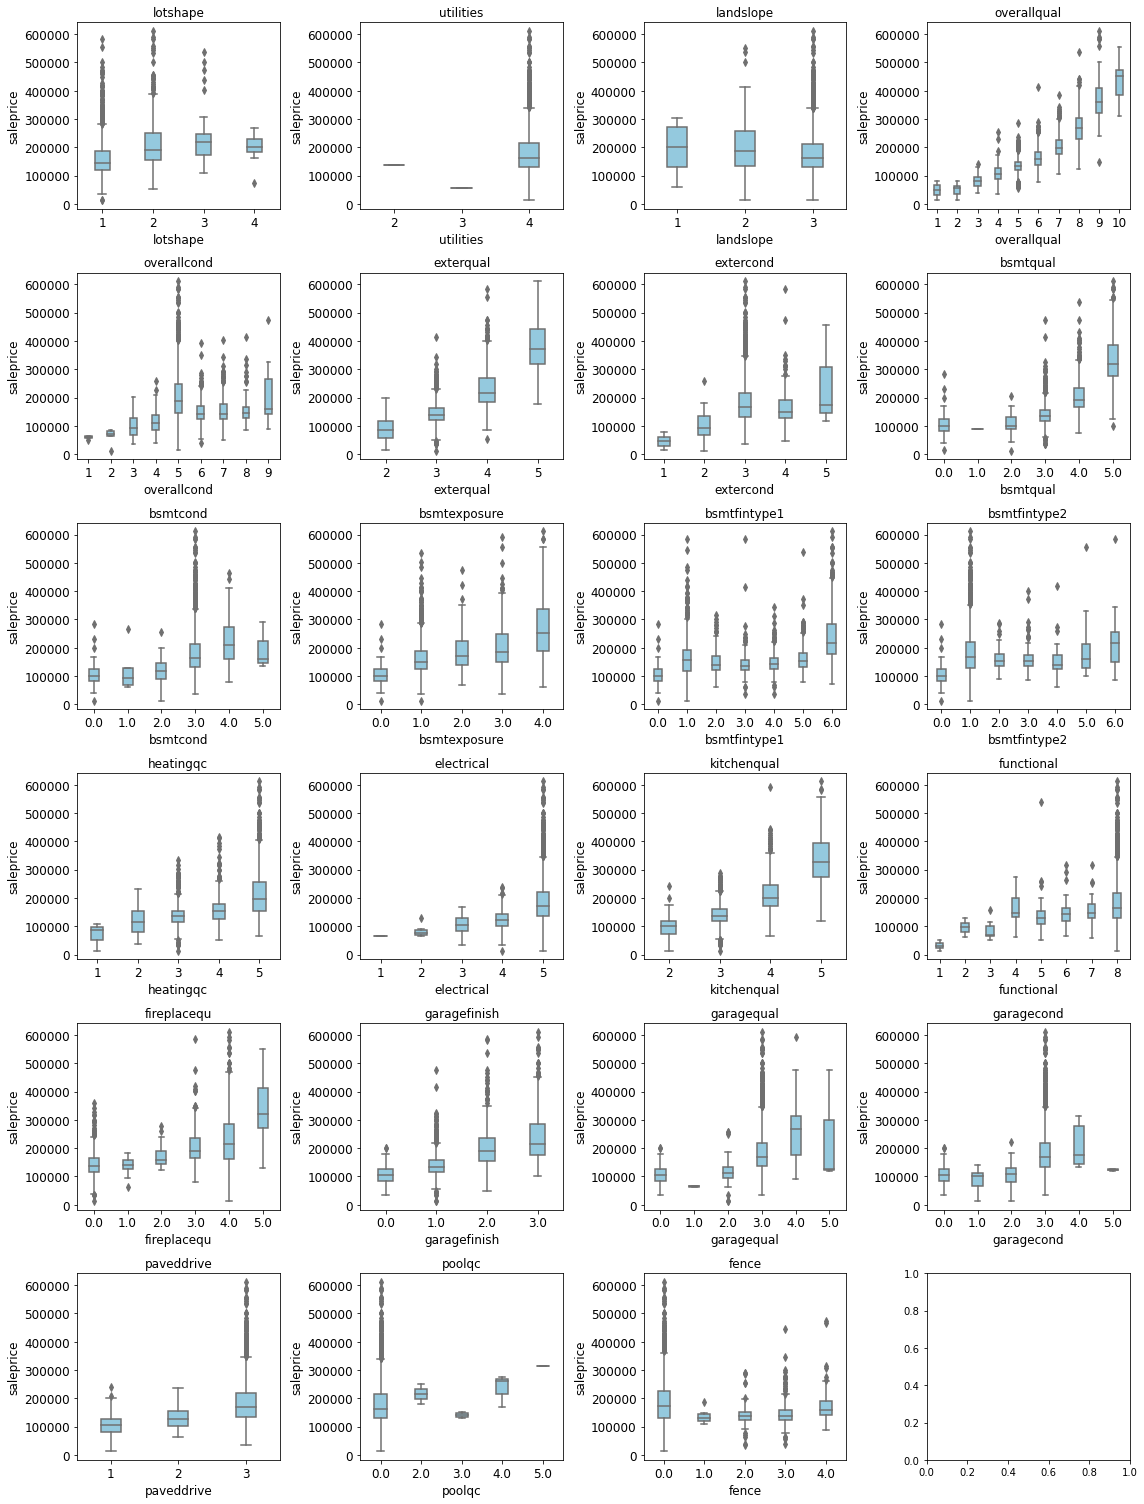

In [74]:
subplot_box(house_tr, ords)

From the boxplots we note that for features like overallqual, bsmtqual, fireplacequ and garagefinish, the median price increases with an increase in quality. This implies a positive correlation.

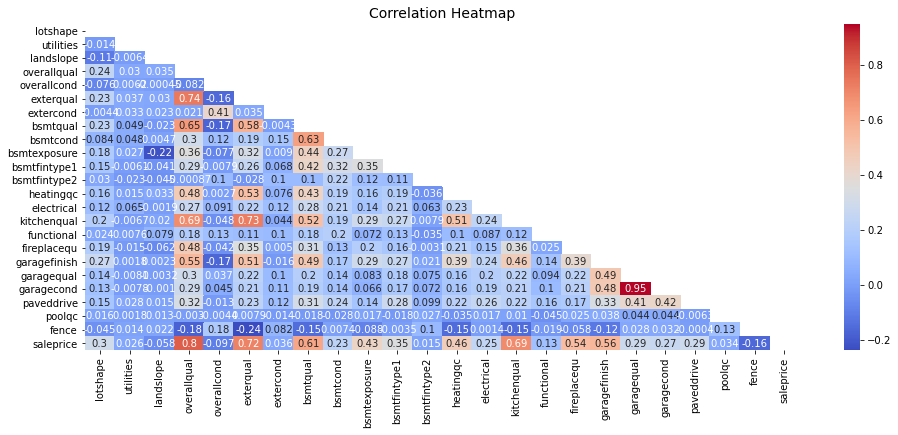

In [75]:
heat_map(house_tr, ords)

In [76]:
house_tr[ords].corr()[['saleprice']].sort_values(by='saleprice', ascending=False)

,saleprice
saleprice,1.000000
overallqual,0.803464
exterqual,0.715027
kitchenqual,0.694548
bsmtqual,0.613414
garagefinish,0.558727
fireplacequ,0.539445
heatingqc,0.458903
bsmtexposure,0.427150
bsmtfintype1,0.350907


There are many ordinal features we can keep here, but we are wary of the issue of multicollinearity as mentioned earlier. Some of these variables have strong correlations to each other, e.g. overallqual and exterqual (around 0.74). A way to keep them and minimise multicollinearity would be to combine them together linearly.

In [77]:
# linear combination of ordinal features for quality

house_tr['totalqual'] = house_tr['overallqual'] + house_tr['exterqual'] + house_tr['kitchenqual'] + house_tr['bsmtqual']

In [78]:
house_tr[['saleprice', 'totalqual']].corr() #totalqual has a stronger correlation than overallqual

,saleprice,totalqual
saleprice,1.00,0.83
totalqual,0.83,1.00


For ordinal features, we will only keep totalqual and garagefinish. This is because fireplacequ previously had a lot of null values (1,000) so it might not be useful as a feature for model prediction.

In [79]:
keep_ords = ['totalqual', 'garagefinish']
drop_ords = [x for x in ords if x not in keep_ords]

In [80]:
drop_features.extend(drop_ords)

In [81]:
drop_features = list(set(drop_features))

In [82]:
len(drop_features)

51

#### Exploring Nominal Features

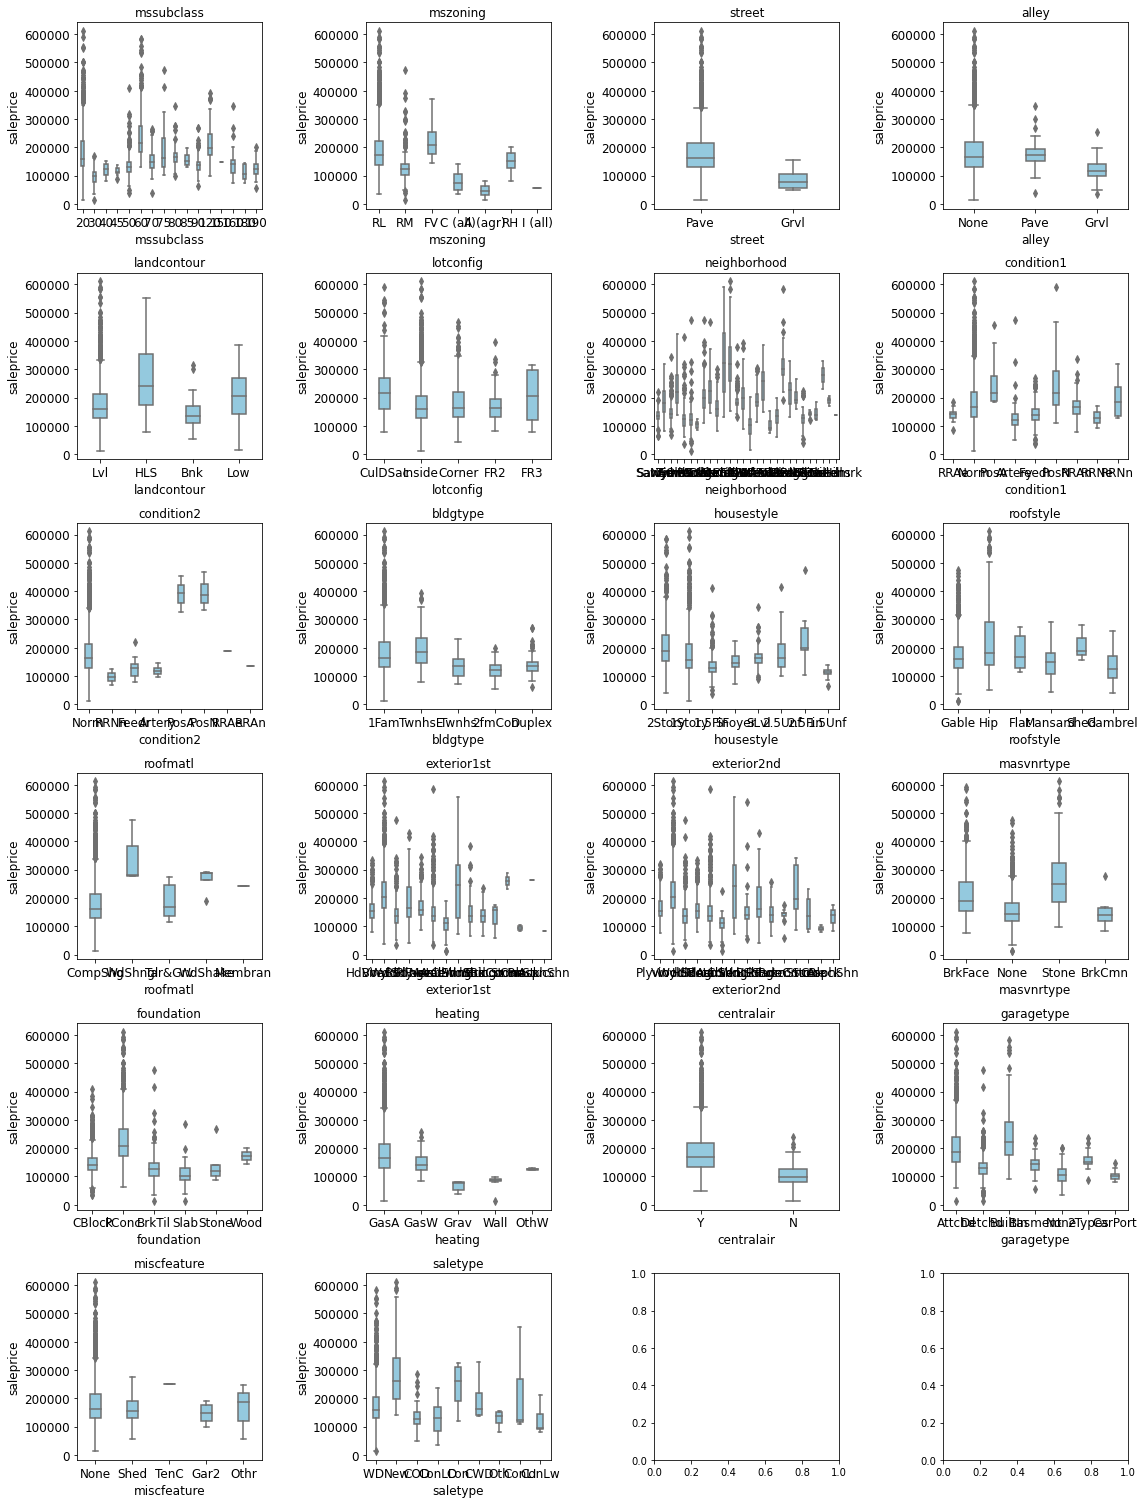

In [83]:
subplot_box(house_tr, noms)

For nominal variables, we want to look at variability, meaning the value counts for each category is reasonably spread out, and not concentrated on one category. For this, we will plot bar charts to explore these features to determine which feature to keep and encode. We will also set a threshold of 50%, meaning if more than 50% of the data is concentrated in only one category for a particular feature, we will drop that feature.

In [84]:
# bar chart function

def subplot_bar(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(16, nrows*6)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.barplot(x = dataframe[column].values, y = dataframe[column].index, ax = ax[i], color='skyblue')
        ax[i].set_title(column,fontsize=12)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=12)
        ax[i].set_ylabel('value_counts', fontsize=12)
        ax[i].axhline(house_tr.shape[0]*0.5)
    plt.tight_layout()

In [85]:
house_tr['mssubclass'] = house_tr['mssubclass'].astype(str) #convert into string type as it was int

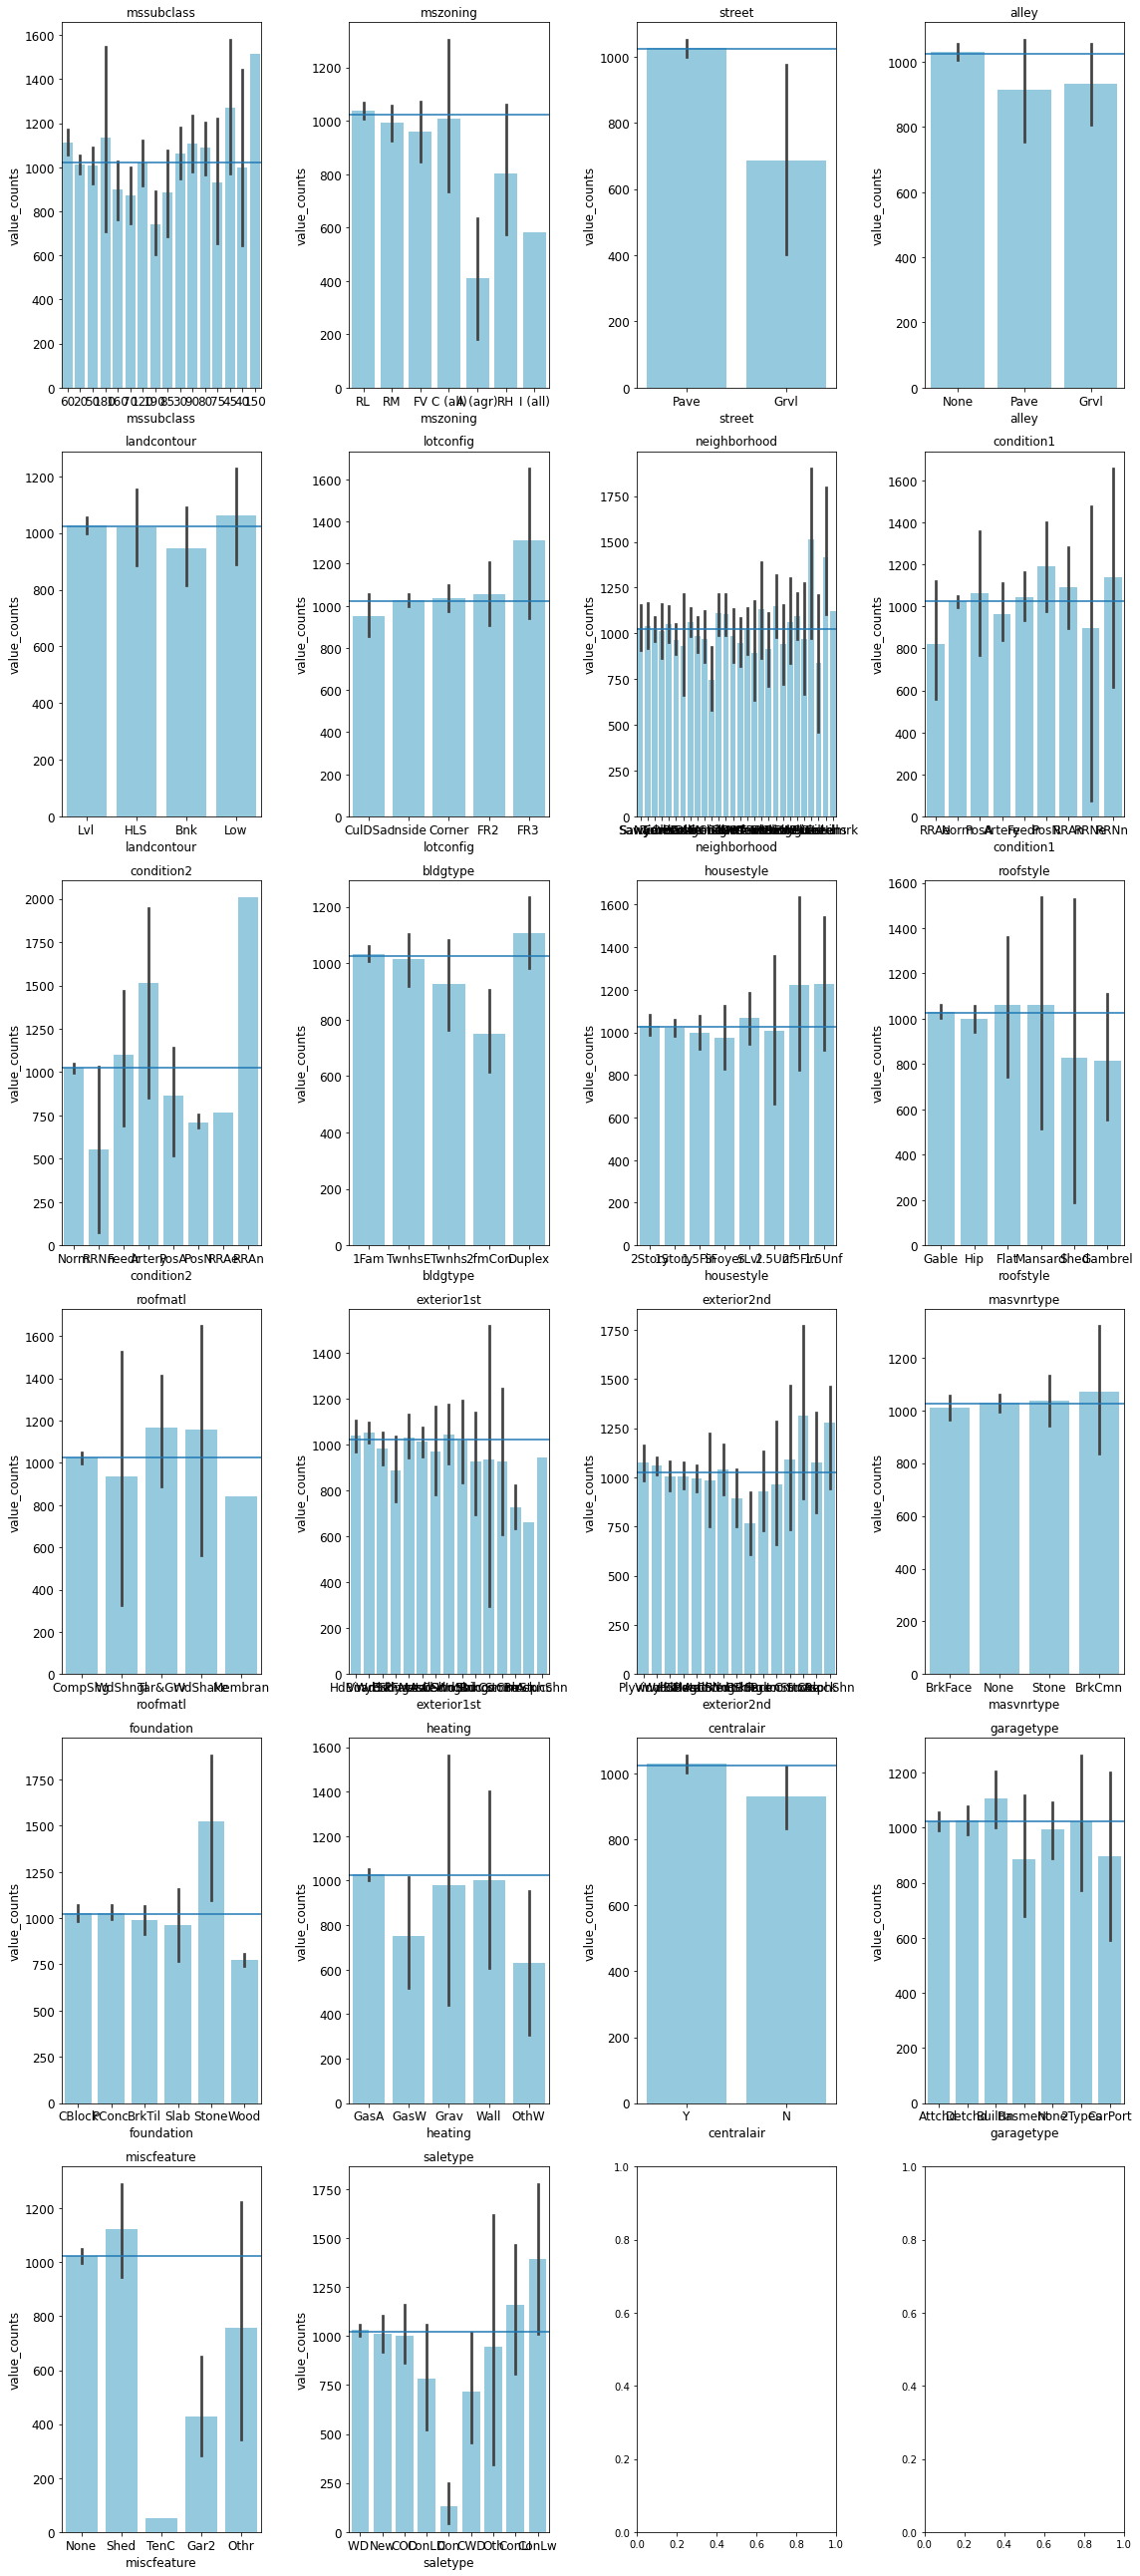

In [86]:
subplot_bar(house_tr, noms)

We see that mssubclass, lotconfig, neighborhood, condition1, condition2, bldgtype, saletype, housestyle, roofstyle, roofmatl, masvnrtype, exterior1st, exterior2nd and saletype seem to have at least more than 1 category of values at above 60% of the data. This indicates variability. 

We will further explore some of these features.

#### Nominal feature - neighborhood

In [87]:
house_tr['neighborhood'].value_counts()

NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      68
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64

By instinct, we know that neighborhood will likely influence sale prices. Therefore, we will attempt to plot a bar chart to explore which neighborhood has the highest sale prices. 

<AxesSubplot:xlabel='saleprice', ylabel='neighborhood'>

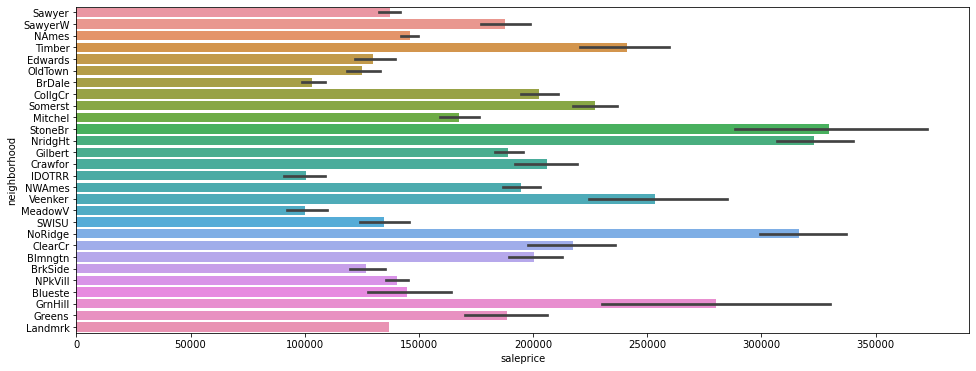

In [88]:
plt.figure(figsize=(16,6))
sns.barplot(x=house_tr['saleprice'], y=house_tr['neighborhood'])

We see that StoneBrook (StoneBr) and Northridge Heights (NridgHt) have the highest sale prices.

#### Nominal features condition1 and condition2

In [89]:
house_tr['condition1'].value_counts()

Norm      1765
Feedr      108
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: condition1, dtype: int64

In [90]:
house_tr[['condition1']].head()

,condition1
0,RRAe
1,Norm
2,Norm
3,Norm
4,Norm


In [91]:
house_tr['condition2'].value_counts()

Norm      2022
Feedr       11
Artery       5
PosA         3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: condition2, dtype: int64

Upon closer examination of value counts, it seems like condition1 and condition2 have more than 50% of values in 'Norm'. We will drop condition 1 and 2.

#### Nominal features - exterior1st and exterior2nd 

In [92]:
house_tr['exterior1st'].value_counts()

VinylSd    724
MetalSd    331
HdBoard    300
Wd Sdng    275
Plywood    152
CemntBd     89
BrkFace     64
WdShing     45
AsbShng     33
Stucco      26
BrkComm      3
CBlock       2
Stone        2
AsphShn      1
ImStucc      1
Name: exterior1st, dtype: int64

In [93]:
house_tr['exterior2nd'].value_counts()

VinylSd    721
MetalSd    324
HdBoard    275
Wd Sdng    262
Plywood    184
CmentBd     89
Wd Shng     63
BrkFace     34
Stucco      29
AsbShng     28
Brk Cmn     17
ImStucc     11
Stone        6
AsphShn      3
CBlock       2
Name: exterior2nd, dtype: int64

We will want to combine exterior1st and exterior2nd as they have the same categories. We also note that there is some typo error on exterior2nd. The terms are not the same as that of the data dictionary.

In [94]:
house_tr['exterior2nd'] = house_tr['exterior2nd'].replace('CmentBd', 'CemntBd')

In [95]:
house_tr['exterior2nd'] = house_tr['exterior2nd'].replace('Wd Shng', 'WdShing')

In [96]:
house_tr['combined_exterior'] = house_tr['exterior1st'] + house_tr['exterior2nd']

In [97]:
# add unwanted columns into drop_features list
keep_noms = ['combined_exterior', 'mssubclass', 'neigborhood', 'foundation', 'bldgtype', 'saletype', 'housestyle', 
             'roofstyle', 'roofmatl', 'masvnrtype', 'lotconfig', 'saletype' ]
drop_noms = [x for x in noms if x not in keep_noms]
drop_noms.remove('neighborhood')

In [98]:
drop_features.extend(drop_noms)

In [99]:
drop_features = list(set(drop_features))

In [100]:
len(drop_features)

61

In [101]:
drop_features.remove('saleprice')

### Dropping Features <a class="anchor" id="dropf"></a>

Earlier we identified a list of features to drop. We will proceed to do that. This will be the last step for our EDA and feature selection.

In [102]:
keep_features = [x for x in house_tr.columns if x not in drop_features]
keep_features.remove('pid')

In [103]:
keep_features

['id',
 'mssubclass',
 'lotconfig',
 'neighborhood',
 'bldgtype',
 'housestyle',
 'yearbuilt',
 'yearremod/add',
 'roofstyle',
 'roofmatl',
 'masvnrtype',
 'masvnrarea',
 'foundation',
 'totalbsmtsf',
 'grlivarea',
 'fullbath',
 'totrmsabvgrd',
 'garagefinish',
 'garagecars',
 'saletype',
 'saleprice',
 'agesold',
 'total_sqft',
 'totalqual',
 'combined_exterior']

In [104]:
drop_features.remove('landscape') #made a typo error earlier, amending it now

In [105]:
drop_features.append('landslope')

In [106]:
#dropping features
house_tr.drop(columns = drop_features, inplace=True)

In [107]:
house_tr.head()

,id,pid,mssubclass,lotconfig,neighborhood,bldgtype,housestyle,yearbuilt,yearremod/add,roofstyle,roofmatl,masvnrtype,masvnrarea,foundation,totalbsmtsf,grlivarea,fullbath,totrmsabvgrd,garagefinish,garagecars,saletype,saleprice,agesold,total_sqft,totalqual,combined_exterior
0,109,533352170,60,CulDSac,Sawyer,1Fam,2Story,1976,2005,Gable,CompShg,BrkFace,289.0,CBlock,725.0,1479,2,6,2.0,2.0,WD,130500,34,2679.0,17.0,HdBoardPlywood
1,544,531379050,60,CulDSac,SawyerW,1Fam,2Story,1996,1997,Gable,CompShg,BrkFace,132.0,PConc,913.0,2122,2,8,2.0,2.0,WD,220000,13,3594.0,19.0,VinylSdVinylSd
2,153,535304180,20,Inside,NAmes,1Fam,1Story,1953,2007,Gable,CompShg,None,0.0,CBlock,1057.0,1057,1,5,1.0,1.0,WD,109000,57,2360.0,15.0,VinylSdVinylSd
3,318,916386060,60,Inside,Timber,1Fam,2Story,2006,2007,Gable,CompShg,None,0.0,PConc,384.0,1444,2,7,3.0,2.0,WD,174000,4,2228.0,15.0,VinylSdVinylSd
4,255,906425045,50,Inside,SawyerW,1Fam,1.5Fin,1900,1993,Gable,CompShg,None,0.0,PConc,676.0,1445,2,6,1.0,2.0,WD,138500,110,2605.0,14.0,Wd SdngPlywood


In [108]:
#removing pid
house_tr.drop(columns='pid', inplace=True)

In [111]:
house_tr.columns #after dropping features, we have 23 remaining.

Index(['id', 'mssubclass', 'lotconfig', 'neighborhood', 'bldgtype',
       'housestyle', 'yearbuilt', 'yearremod/add', 'roofstyle', 'roofmatl',
       'masvnrtype', 'masvnrarea', 'foundation', 'totalbsmtsf', 'grlivarea',
       'fullbath', 'totrmsabvgrd', 'garagefinish', 'garagecars', 'saletype',
       'saleprice', 'agesold', 'total_sqft', 'totalqual', 'combined_exterior'],
      dtype='object')

In [112]:
house_tr.shape

(2048, 25)

In [113]:
#saving final copy of train csv
house_tr.to_csv('datasets/train_final.csv')